<a href="https://colab.research.google.com/github/salsabillaflsft/ABSApublic/blob/main/theinnerworkings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformers - BERT - IndoBERT : inner workings**

## Installation

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from transformers import (BertTokenizer, BertConfig, BertForPreTraining, BertPreTrainedModel, 
                          apply_chunking_to_forward, BertModel, set_seed)
from transformers.activations import gelu
from transformers.modeling_outputs import (BaseModelOutputWithPastAndCrossAttentions, 
                                           BaseModelOutputWithPoolingAndCrossAttentions, 
                                           SequenceClassifierOutput)

import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [7]:
# Set seed for reproducibility.
set_seed(123)

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = 3

# GELU Activation function.
ACT2FN = {"gelu": gelu}

# Define BertLayerNorm.
BertLayerNorm = torch.nn.LayerNorm

## Load Data

Dataset 

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/TA/Dataset

In [17]:
# dataset_folder_path = '/content/drive/MyDrive//TA/Dataset'

In [18]:
# train_dataset_path = dataset_folder_path + '/train_preprocess_70.csv'
# valid_dataset_path = dataset_folder_path + '/val_preprocess_15.csv'
# test_dataset_path = dataset_folder_path + '/test_preprocess_15.csv'

In [19]:
#example 11-3-4-5-6
data = [
    "Tempatnya asyik utk nyantai bareng teman2 ,  walau gang masuk nya sempit .  Mobil parkir di jalan besar .",
    "Tempatnya enak ,  menunya enak tp pegawainya kok songong yaa .  Kapok sih ,  ga bakalan ke sana lagi",
    "Tempat nongkrong jaman maba banget nyaman sih buat nugas",
    "Agak panas dan tumben penuh padahal siang2 kesana",
    "Cocok kalo untuk kerja atau nugas",
]

# labels = ["positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           "negative,	negative,	positive,	neutral,	neutral,	positive",
#           "positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           "positive,	neutral,	neutral,	neutral,	negative,	neutral",
#           "positive,	neutral,	neutral,	neutral,	neutral,	positive",
#           ]

aspects = ['umum','layanan','menu','harga','fasilitas','suasana']

labels = [[2,	1,	1,	1,	1,	2],
          [0,	0,	2,	1,	1,	2],
          [2,	1,	1,	1,	1,	2],
          [2,	1,	1,	1,	0,	1],
          [2,	1,	1,	1,	1,	2],
          ]

## Modules (dataset)

In [20]:
class AspectBasedSentimentAnalysisDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = ['umum','layanan','menu','harga','fasilitas','suasana']
    LABEL2INDEX = {'negative': 0, 'neutral': 1, 'positive': 2}
    INDEX2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    NUM_LABELS = [3, 3, 3, 3, 3, 3]
    NUM_ASPECTS = 6
    
    def load_dataset(self, path):
        df = pd.read_csv(path)
        for aspect in self.ASPECT_DOMAIN:
            df[aspect] = df[aspect].apply(lambda sen: self.LABEL2INDEX[sen])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
        
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        sentence, labels = data['review_text'], [data[aspect] for aspect in self.ASPECT_DOMAIN]
        subwords = self.tokenizer.encode(sentence, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['review_text']
    
    def __len__(self):
        return len(self.data)

class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, self.num_aspects), dtype=np.int64)

        seq_list = []
        
        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i,:] = label

            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, label_batch, seq_list

MultiLabel

In [21]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list

        self.bert = BertModel(config)  #bert model layer
        self.dropout = nn.Dropout(config.hidden_dropout_prob)  #bert dropout layer
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels]) #bert classification layer

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

## Load Model, Tokenizer, Config

In [22]:
# Load Tokenizer, Config, Model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

config.num_labels = max(AspectBasedSentimentAnalysisDataset.NUM_LABELS)
config.num_labels_list = AspectBasedSentimentAnalysisDataset.NUM_LABELS
model = BertForMultiLabelClassification.from_pretrained('indobenchmark/indobert-base-p1',config=config)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.5.weight', 'classifiers.3.bias', 'classifiers.1.bias', 'classifiers.2.bias', 'classifiers.0.bias', 'classifiers.0.weight', 'classifiers.2.weight', 'classifiers.4.bias', 'classifiers.3.weight', 'classifiers.5.bias', 'classifiers.1.weight', 'classifiers.4.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print('NUMBER OF LAYERS:', config.num_hidden_layers)

print('EMBEDDING SIZE:', config.hidden_size)

print('ACTIVATIONS:', config.hidden_act)

NUMBER OF LAYERS: 12
EMBEDDING SIZE: 768
ACTIVATIONS: gelu


In [24]:
model

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [25]:
# train_dataset = AspectBasedSentimentAnalysisDataset(train_dataset_path, tokenizer, lowercase=True)
# valid_dataset = AspectBasedSentimentAnalysisDataset(valid_dataset_path, tokenizer, lowercase=True)
# test_dataset = AspectBasedSentimentAnalysisDataset(test_dataset_path, tokenizer, lowercase=True)

In [26]:
# train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=True)  
# valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)  
# test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=2, shuffle=False)

## Pre-Processing - Tokenizer - WordPiece

tokenization, token to ids, special tokens, label *encoding*, padding truncating, att masks

WordPiece tokenization - the inner workings -> [wordpiece inner workings](https://colab.research.google.com/drive/1LYVJDlsFje9DNUvpS1gQybpbN9j7NrHb?usp=sharing)

In [30]:
input_sequences = tokenizer(text=data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt')
input_sequences.update({'labels':torch.tensor(labels)})

[print('%s : %s\n'%(k,v)) for k,v in input_sequences.items()];

input_ids : tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2040,  1686,    90,   494,   158, 19287,    22,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [31]:
[print(tokenizer.decode(example)) for example in input_sequences['input_ids'].numpy()];

[CLS] tempatnya asyik utk nyantai bareng teman2, walau gang masuk nya sempit. mobil parkir di jalan besar. [SEP] [PAD]
[CLS] tempatnya enak, menunya enak tp pegawainya kok songong yaa. kapok sih, ga bakalan ke sana lagi [SEP]
[CLS] tempat nongkrong jaman maba banget nyaman sih buat nugas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] agak panas dan tumben penuh padahal siang2 kesana [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] cocok kalo untuk kerja atau nugas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### result based on all data

In [32]:
# # example on pre-processing based on all data
# train_dataset[9]

In [33]:
# # Get an iterator for the train_loader
# train_iter = iter(train_loader)

# # Get the first batch of data
# batch_data = next(train_iter)

In [34]:
# batch_data # this shows the token to ids(padded to same length, special tokens added), attention masks, label(encoded), the data)

## BERT Embedding: Token - Segment - Position

In [35]:
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

### PE

positional encoding/embedding
- transformer takes all the embedding at once
- filling with the words order will distort the infos
- added normalization will confuse the model

PE -> used frequencies to capture data infos


PE(𝑝𝑜𝑠,2𝑖)=𝑠𝑖𝑛(𝑝𝑜𝑠/(10000^2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙))
 
PE(𝑝𝑜𝑠,2𝑖+1)=𝑐𝑜𝑠(𝑝𝑜𝑠/(10000^2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙))

pos = position of the word (max sequence length = 512)(in this, length of tokens = 25)

i = indices, dimensions of the embedding (768)

dmodel = dimension/size of the embedding 
(BERT embedding size -> 768) 

with this formulas/calculation, each word with diff positions will have different position embeddings values


In [36]:
# class PositionalEncoding(nn.Module):
#     "Implement the PE function."

#     def __init__(self, d_model, dropout, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer("pe", pe)

#     def forward(self, x):
#         x = x + self.pe[:, : x.size(1)].requires_grad_(False)
#         return self.dropout(x)

In [37]:
# def show_example(fn, args=[]):
#     if __name__ == "__main__":
#         return fn(*args)

# def example_positional():
#     pe = PositionalEncoding(20, 0)
#     y = pe.forward(torch.zeros(1, 100, 20))

#     data = pd.concat(
#         [
#             pd.DataFrame(
#                 {
#                     "embedding": y[0, :, dim],
#                     "dimension": dim,
#                     "position": list(range(100)),
#                 }
#             )
#             for dim in [4, 5, 6, 7]
#         ]
#     )

#     return (
#         alt.Chart(data)
#         .mark_line()
#         .properties(width=800)
#         .encode(x="position", y="embedding", color="dimension:N")
#         .interactive()
#     )


# show_example(example_positional)

In [38]:
# #for pos embedding visualizations, include pos encoding formulas
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# def pos_visualize(position_embeddings):
#     # Extract the shape of the position embeddings.
#     _, pos, d_model = position_embeddings.shape #[1,25,78]
    
#     even_i = np.arange(0, d_model, 2, dtype='int')
#     odd_i = np.arange(1, d_model, 2, dtype='int')
#     pe_1 = []
#     pe_2 = []

#     for _pos in range(pos):
#         pe_even = np.sin(_pos / np.power(10000, (2 * even_i / d_model)))
#         pe_odd = np.cos(_pos / np.power(10000, (2 * odd_i / d_model)))
#         pe_1.append(np.insert(pe_even, list(range(1, len(pe_odd) + 1)), pe_odd))
#         pe_2.append(np.concatenate([pe_even, pe_odd]))

#     # Create heatmaps to visualize the positional embeddings.
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     sns.heatmap(pe_1, cmap='GnBu')
#     plt.title('Sine Positional Embeddings')
#     plt.xlabel('Embedding Dimension')
#     plt.ylabel('Position')
#     plt.subplot(1, 2, 2)
#     sns.heatmap(pe_2, cmap='GnBu')
#     plt.title('Cosine Positional Embeddings')
#     plt.xlabel('Embedding Dimension')
#     plt.ylabel('Position')
#     plt.tight_layout()
#     plt.show()

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def pos_visualize(position_embeddings):
    # Extract the shape of the position embeddings.
    _, pos, d_model = position_embeddings.shape 
    
    # Compute the positional encodings.
    pe = np.zeros((pos, d_model))
    for pos_idx in range(pos):
        for i in range(0, d_model, 2):
            pe[pos_idx, i] = np.sin(pos_idx / (10000 ** ((2*i) / d_model)))
            pe[pos_idx, i+1] = np.cos(pos_idx / (10000 ** ((2*i+1) / d_model)))
    
    # Plot the positional encodings.
    plt.figure(figsize=(10, 5))
    sns.heatmap(pe, cmap='GnBu')
    plt.title('Positional Embeddings')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.tight_layout()
    plt.show()

### Results

Created Tokens Positions IDs:
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]])

Tokens IDs shape:
 torch.Size([5, 25])

Tokens IDs:
 tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0

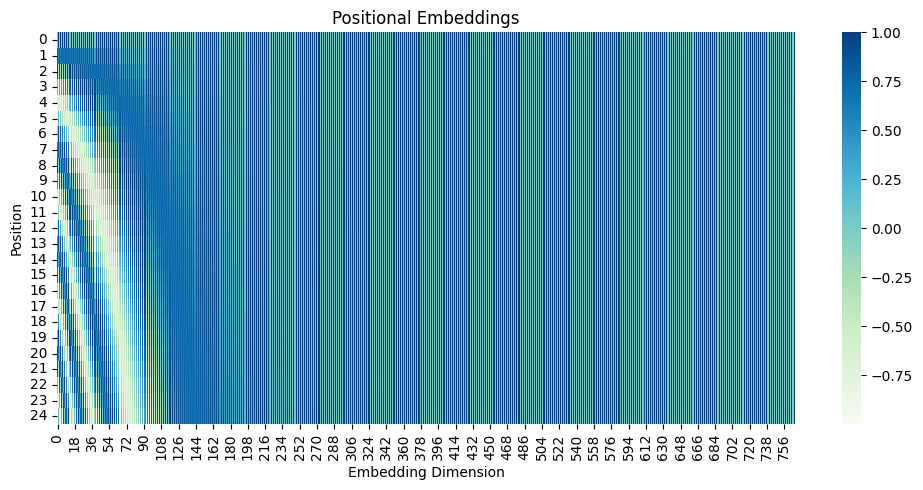


Token Types Embeddings:
 torch.Size([5, 25, 768])

Token Types Embeddings:
 tensor([[[-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         ...,
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643]],

        [[-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         ...,
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643],
         [-0.5468, -0.4178, -1.0258,  ..., -1.5387, -0.9375,  1.5643]],

        [[-0.5468, -0.4178, -1.0258,  .

In [40]:
class BertEmbeddings(torch.nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = torch.nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = torch.nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = torch.nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load any TensorFlow checkpoint file
        self.LayerNorm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        print('Created Tokens Positions IDs:\n', position_ids)        

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # Inputs IDS
        print('\nTokens IDs shape:\n', input_ids.shape)
        print('\nTokens IDs:\n', input_ids)
        # Segment Embedding
        print('\nTokens Type IDs shape:\n', token_type_ids.shape)
        print('\nTokens Type IDs / Segments:\n', token_type_ids)
        # Token Embedding
        print('\nWord Embeddings shape:\n', inputs_embeds.shape)
        print('\nWord Embeddings #1:\n', inputs_embeds)


        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)

            # Position Embedding
            print('\nPosition Embeddings:\n', position_embeddings.shape)
            print('\nPosition Embeddings:\n', position_embeddings)
            embeddings += position_embeddings
            pos_visualize(position_embeddings)

        print('\nToken Types Embeddings:\n', token_type_embeddings.shape)
        print('\nToken Types Embeddings:\n', token_type_embeddings)
        
        print('\nSum Up All Embeddings:\n', embeddings.shape)
        print('\nResult:\n', embeddings)

        embeddings = self.LayerNorm(embeddings)

        print('\nEmbeddings Layer Normalization:\n', embeddings.shape)

        embeddings = self.dropout(embeddings)

        print('\nEmbeddings Dropout Layer:\n', embeddings.shape)
        
        return embeddings


# Create Bert embedding layer.
bert_embeddings_block = BertEmbeddings(config)

# Perform a forward pass.
embedding_output = bert_embeddings_block.forward(input_ids=input_sequences['input_ids'], token_type_ids=input_sequences['token_type_ids'])

## build encoder

### transformer paper

In [41]:
# def attention(query, key, value, mask=None, dropout=None):
#     "Compute 'Scaled Dot Product Attention'"
#     d_k = query.size(-1)
#     scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, -1e9)
#     p_attn = scores.softmax(dim=-1)
#     if dropout is not None:
#         p_attn = dropout(p_attn)
#     return torch.matmul(p_attn, value), p_attn

In [42]:
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, h, d_model, dropout=0.1):
#         "Take in model size and number of heads."
#         super(MultiHeadedAttention, self).__init__()
#         assert d_model % h == 0
#         # We assume d_v always equals d_k
#         self.d_k = d_model // h
#         self.h = h
#         self.linears = clones(nn.Linear(d_model, d_model), 4)
#         self.attn = None
#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, query, key, value, mask=None):
#         "Implements Figure 2"
#         if mask is not None:
#             # Same mask applied to all h heads.
#             mask = mask.unsqueeze(1)
#         nbatches = query.size(0)

#         # 1) Do all the linear projections in batch from d_model => h x d_k
#         query, key, value = [
#             lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
#             for lin, x in zip(self.linears, (query, key, value))
#         ]

#         # 2) Apply attention on all the projected vectors in batch.
#         x, self.attn = attention(
#             query, key, value, mask=mask, dropout=self.dropout
#         )

#         # 3) "Concat" using a view and apply a final linear.
#         x = (
#             x.transpose(1, 2)
#             .contiguous()
#             .view(nbatches, -1, self.h * self.d_k)
#         )
#         del query
#         del key
#         del value
#         return self.linears[-1](x)

In [43]:
# def viz_encoder_self():
#     model, example_data = run_model_example(n_examples=1)
#     example = example_data[
#         len(example_data) - 1
#     ]  # batch object for the final example

#     layer_viz = [
#         visualize_layer(
#             model, layer, get_encoder, len(example[1]), example[1], example[1]
#         )
#         for layer in range(6)
#     ]
#     return alt.hconcat(
#         layer_viz[0]
#         # & layer_viz[1]
#         & layer_viz[2]
#         # & layer_viz[3]
#         & layer_viz[4]
#         # & layer_viz[5]
#     )


# show_example(viz_encoder_self)

### Self Attention and Self Output

In [44]:
class BertSelfAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # size of attention head
        print('Attention Head Size:\n', self.attention_head_size)
        print('\nCombined Attentions Head Size:\n', self.all_head_size)
        # linear Q K V
        self.query = torch.nn.Linear(config.hidden_size, self.all_head_size)
        self.key = torch.nn.Linear(config.hidden_size, self.all_head_size)
        self.value = torch.nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = torch.nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        print('\nHidden States:\n', hidden_states.shape)

        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:

            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', past_key_value[0].shape)
            print('\nValue Linear Layer:\n', past_key_value[1].shape)

            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:

            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(encoder_hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(encoder_hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:

            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:

            print('\nQuery Linear Layer:\n', mixed_query_layer.shape)
            print('\nKey Linear Layer:\n', self.key(hidden_states).shape)
            print('\nValue Linear Layer:\n', self.value(hidden_states).shape)

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))


        query_layer = self.transpose_for_scores(mixed_query_layer)

        print('\nQuery:\n', query_layer.shape)
        print('\nKey:\n', key_layer.shape)
        print('\nValue:\n', value_layer.shape)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # transpose matrices
        print('\nKey Transposed:\n', key_layer.transpose(-1, -2).shape)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        print('\nAttention Scores:\n', attention_scores.shape)

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        # divided by the dimension of the key vector sqrt of dk
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        print('\nAttention Scores Divided by Scalar:\n', attention_scores.shape)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        # using softmax
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)

        print('\nAttention Probabilities Softmax Layer:\n', attention_probs.shape)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        print('\nAttention Probabilities Dropout Layer:\n', attention_probs.shape)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        print('\nContext:\n', context_layer.shape)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

        print('\nContext Permute:\n', context_layer.shape)

        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        print('\nContext Reshaped:\n', context_layer.shape)
        
        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

# Create bert self attention layer.
bert_selfattention_block = BertSelfAttention(config)

# Perform a forward pass.
context_embedding = bert_selfattention_block.forward(hidden_states=embedding_output)


Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([5, 25, 768])

Query Linear Layer:
 torch.Size([5, 25, 768])

Key Linear Layer:
 torch.Size([5, 25, 768])

Value Linear Layer:
 torch.Size([5, 25, 768])

Query:
 torch.Size([5, 12, 25, 64])

Key:
 torch.Size([5, 12, 25, 64])

Value:
 torch.Size([5, 12, 25, 64])

Key Transposed:
 torch.Size([5, 12, 64, 25])

Attention Scores:
 torch.Size([5, 12, 25, 25])

Attention Scores Divided by Scalar:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Softmax Layer:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Dropout Layer:
 torch.Size([5, 12, 25, 25])

Context:
 torch.Size([5, 12, 25, 64])

Context Permute:
 torch.Size([5, 25, 12, 64])

Context Reshaped:
 torch.Size([5, 25, 768])


In [45]:
class BertSelfOutput(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        print('Hidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.dropout(hidden_states)
        print('\nHidden States Dropout Layer:\n', hidden_states.shape)

        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        print('\nHidden States Normalization Layer:\n', hidden_states.shape)

        return hidden_states


# Create Bert self output layer.
bert_selfoutput_block = BertSelfOutput(config)

# Perform a forward pass - context_embedding[0] because we have tuple.
attention_output = bert_selfoutput_block.forward(hidden_states=context_embedding[0], input_tensor=embedding_output)


Hidden States:
 torch.Size([5, 25, 768])

Hidden States Linear Layer:
 torch.Size([5, 25, 768])

Hidden States Dropout Layer:
 torch.Size([5, 25, 768])

Hidden States Normalization Layer:
 torch.Size([5, 25, 768])


### BERT LAYER #1 Attention -> Self Attention + Output

In [46]:
class BertAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

# Create attention assembled layer.
bert_attention_block = BertAttention(config)

# Perform a forward pass to wholte Bert Attention layer.
attention_output = bert_attention_block(hidden_states=embedding_output)


Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([5, 25, 768])

Query Linear Layer:
 torch.Size([5, 25, 768])

Key Linear Layer:
 torch.Size([5, 25, 768])

Value Linear Layer:
 torch.Size([5, 25, 768])

Query:
 torch.Size([5, 12, 25, 64])

Key:
 torch.Size([5, 12, 25, 64])

Value:
 torch.Size([5, 12, 25, 64])

Key Transposed:
 torch.Size([5, 12, 64, 25])

Attention Scores:
 torch.Size([5, 12, 25, 25])

Attention Scores Divided by Scalar:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Softmax Layer:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Dropout Layer:
 torch.Size([5, 12, 25, 25])

Context:
 torch.Size([5, 12, 25, 64])

Context Permute:
 torch.Size([5, 25, 12, 64])

Context Reshaped:
 torch.Size([5, 25, 768])
Hidden States:
 torch.Size([5, 25, 768])

Hidden States Linear Layer:
 torch.Size([5, 25, 768])

Hidden States Dropout Layer:
 torch.Size([5, 25, 768])

Hidden States Normalization Layer:
 torch.Size([5, 25, 768])


### BERT LAYER #2 Intermediate: FFNN

In [47]:
class BertIntermediate(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        print('\nHidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.intermediate_act_fn(hidden_states)
        print('\nHidden States Gelu Activation Function:\n', hidden_states.shape)

        return hidden_states


# Create bert intermediate layer.
bert_intermediate_block = BertIntermediate(config)

# Perform a forward pass - attention_output[0] because we have tuple.
intermediate_output = bert_intermediate_block.forward(hidden_states=attention_output[0])



Hidden States:
 torch.Size([5, 25, 768])

Hidden States Linear Layer:
 torch.Size([5, 25, 3072])

Hidden States Gelu Activation Function:
 torch.Size([5, 25, 3072])


### BERT LAYER #3 Output: Add+Norm

In [49]:
class BertOutput(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        print('\nHidden States:\n', hidden_states.shape)

        hidden_states = self.dense(hidden_states)
        print('\nHidden States Linear Layer:\n', hidden_states.shape)

        hidden_states = self.dropout(hidden_states)
        print('\nHidden States Dropout Layer:\n', hidden_states.shape)

        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        print('\nHidden States Layer Normalization:\n', hidden_states.shape)

        return hidden_states


# Create bert output layer.
bert_output_block = BertOutput(config)

# Perform forward pass - attention_output[0] dealing with tuple.
layer_output = bert_output_block.forward(hidden_states=intermediate_output, input_tensor=attention_output[0])



Hidden States:
 torch.Size([5, 25, 3072])

Hidden States Linear Layer:
 torch.Size([5, 25, 768])

Hidden States Dropout Layer:
 torch.Size([5, 25, 768])

Hidden States Layer Normalization:
 torch.Size([5, 25, 768])


[transformers inner workings](http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding)

[bert inner workings](https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/)


[bert visualization](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing)

## BERT Encoder: Self Attention - Multi-Head Attention

### Self Attention

In [52]:
class BertLayer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            assert self.is_decoder, f"{self} should be used as a decoder model if cross attention is added"
            self.crossattention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            assert hasattr(
                self, "crossattention"
            ), f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers by setting `config.add_cross_attention=True`"

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output



# Assemble block to create Bert Layer.
bert_layer_block = BertLayer(config)

# Perform feed forward on a whole Bert Layer.
layer_output = bert_layer_block.forward(hidden_states=embedding_output)


Attention Head Size:
 64

Combined Attentions Head Size:
 768

Hidden States:
 torch.Size([5, 25, 768])

Query Linear Layer:
 torch.Size([5, 25, 768])

Key Linear Layer:
 torch.Size([5, 25, 768])

Value Linear Layer:
 torch.Size([5, 25, 768])

Query:
 torch.Size([5, 12, 25, 64])

Key:
 torch.Size([5, 12, 25, 64])

Value:
 torch.Size([5, 12, 25, 64])

Key Transposed:
 torch.Size([5, 12, 64, 25])

Attention Scores:
 torch.Size([5, 12, 25, 25])

Attention Scores Divided by Scalar:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Softmax Layer:
 torch.Size([5, 12, 25, 25])

Attention Probabilities Dropout Layer:
 torch.Size([5, 12, 25, 25])

Context:
 torch.Size([5, 12, 25, 64])

Context Permute:
 torch.Size([5, 25, 12, 64])

Context Reshaped:
 torch.Size([5, 25, 768])
Hidden States:
 torch.Size([5, 25, 768])

Hidden States Linear Layer:
 torch.Size([5, 25, 768])

Hidden States Dropout Layer:
 torch.Size([5, 25, 768])

Hidden States Normalization Layer:
 torch.Size([5, 25, 768])

Hidd

### Multi-Head Attention

In [55]:
class BertEncoder(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = torch.nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):

            # ADDED
            print('\n----------------- BERT LAYER %d -----------------'%(i+1))

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None
            if getattr(self.config, "gradient_checkpointing", False):

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

# create bert encoder block by stacking 12 layers
bert_encoder_block = BertEncoder(config)

# perform forward pass on entire Bert Encoder
encoder_embedding = bert_encoder_block.forward(hidden_states=embedding_output)


Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768

----------------- BERT LAYER 1 -----------------

Hidden States:
 torch.Size([5, 25, 768])

Query Linear Layer:
 torch.Size([5, 25, 768])

Key Linear Layer:
 torch.Size([5, 25, 768])

Value Linear Layer:
 torch.Size([5, 25, 768])

Query:
 torch.Size([5, 1

## BERT Pooler

In [57]:
class BertPooler(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = torch.nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
       
        print('\nHidden States:\n', hidden_states.shape)

        first_token_tensor = hidden_states[:, 0]
        print('\nFirst Token [CLS]:\n', first_token_tensor.shape)

        pooled_output = self.dense(first_token_tensor)
        print('\nFirst Token [CLS] Linear Layer:\n', pooled_output.shape)

        pooled_output = self.activation(pooled_output)
        print('\nFirst Token [CLS] Tanh Activation Function:\n', pooled_output.shape)

        return pooled_output


# Create bert pooler block.
bert_pooler_block = BertPooler(config)

# Perform forward pass - encoder_embedding[0] because it is a tuple.
pooled_output = bert_pooler_block(hidden_states=encoder_embedding[0])



Hidden States:
 torch.Size([5, 25, 768])

First Token [CLS]:
 torch.Size([5, 768])

First Token [CLS] Linear Layer:
 torch.Size([5, 768])

First Token [CLS] Tanh Activation Function:
 torch.Size([5, 768])


## BERT Model: Encoder + Pooler

Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768


/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Created Tokens Positions IDs:
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]])

Tokens IDs shape:
 torch.Size([5, 25])

Tokens IDs:
 tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0

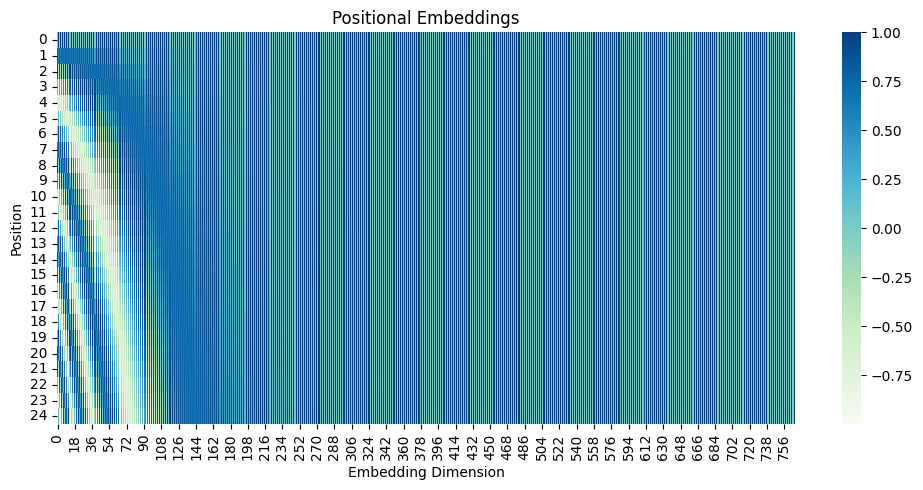


Token Types Embeddings:
 torch.Size([5, 25, 768])

Token Types Embeddings:
 tensor([[[-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         ...,
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261]],

        [[-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         ...,
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261],
         [-0.0297, -0.0425,  0.0011,  ...,  0.0337,  0.0008, -0.0261]],

        [[-0.0297, -0.0425,  0.0011,  .

In [58]:
class BertModel(BertPreTrainedModel):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need <https://arxiv.org/abs/1706.03762>`__ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    To behave as an decoder the model needs to be initialized with the :obj:`is_decoder` argument of the configuration
    set to :obj:`True`. To be used in a Seq2Seq model, the model needs to initialized with both :obj:`is_decoder`
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            batch_size, seq_length = input_shape
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size, seq_length = input_shape
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )


# Create bert model.
bert_model = BertModel(config)

# Perform forward pass on entire model.
hidden_states = bert_model.forward(input_ids=input_sequences['input_ids'], attention_mask=input_sequences['attention_mask'], token_type_ids=input_sequences['token_type_ids'])


## BERT Multi-Label Classification Model

In [60]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`, defaults to :obj:`None`):
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when ``labels`` is provided) :
            Classification loss.
        scores (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, config.num_labels)`)
            Classification scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768
Attention Head Size:
 64

Combined Attentions Head Size:
 768


/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Created Tokens Positions IDs:
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]])

Tokens IDs shape:
 torch.Size([5, 25])

Tokens IDs:
 tensor([[    2,  7229,  8181,  4302,  1107, 12006,    94,  8074,  1614, 30378,
         30468,  1766, 10357,   804,  1107,  7132, 30470,   895,  5222,    26,
           795,   421, 30470,     3,     0],
        [    2,  7229,  3107, 30468,  1622,    57,  3107,  3478,  3027,    57,
          2105, 30052,  2692,  5633, 30470,  1012,   118,  1966, 30468,   525,
         10263,    43,  2377,   423,     3],
        [    2,   515, 16503,  4881,  6943, 30354,  2174,  2382,  1966,   968,
         19287,    22,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [    2,  2839,  1990,    41,  1349,  1771,  1876,  2234,  3346, 30378,
         11105,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0

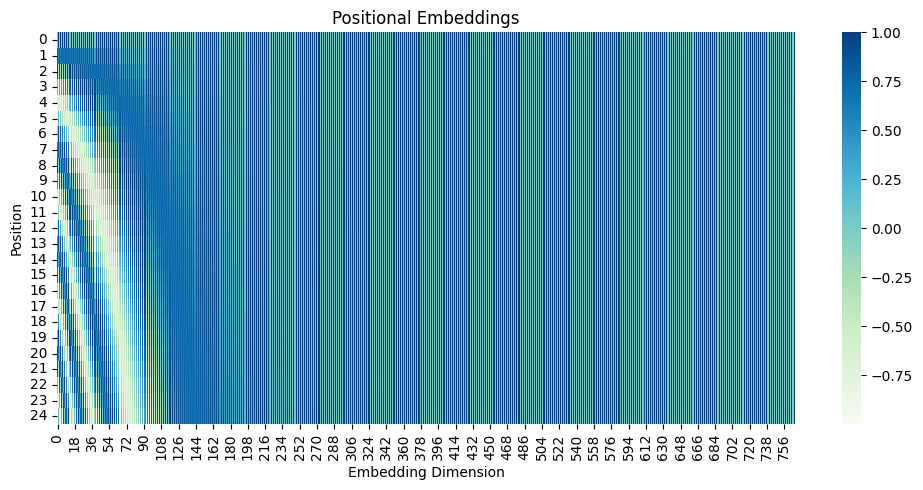


Token Types Embeddings:
 torch.Size([5, 25, 768])

Token Types Embeddings:
 tensor([[[ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         ...,
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032]],

        [[ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         ...,
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032],
         [ 0.0186, -0.0042,  0.0011,  ...,  0.0175, -0.0022,  0.0032]],

        [[ 0.0186, -0.0042,  0.0011,  .

In [61]:
# create Bert model with classification layer - BertForSequenceClassificatin
bert_for_multilabel_classification_model = BertForMultiLabelClassification(config)

# perform forward pass on entire model
outputs = bert_for_multilabel_classification_model(**input_sequences)


## sources


http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding

https://gmihaila.github.io/tutorial_notebooks/bert_inner_workings/

https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing
